In [1]:
import os
import time
import pickle
import random
import pandas as pd
import numpy as np
import torch
from types import SimpleNamespace
from sklearn.preprocessing import MinMaxScaler

# ==============================
# Set args manually (simulate argparse)
# ==============================
args = SimpleNamespace(
    seed=1,
    epoch=20,
    batch_size=16,
    num_enc_layer=4,
    num_dec_layer=4,
    d_long=3,
    num_head=4,
    model_size=16,
    suffix='train',
    model='LSR',
    data='simulated_data',
    local=True,
    Y1_missing=0.0,
    Y2_missing=0.0,
    Y3_missing=0.0,
    inten_weight=0.01,
    surv_weight=0.1,
    lr=0.0003
)

# ==============================
# Set device and seed
# ==============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# ==============================
# Load dataset
# ==============================
dataset_path = f'data/{args.data}.pkl'
data_all = pd.read_pickle(dataset_path)
I = data_all["id"].values[-1] + 1
dag_info_path = f'data/_info.pkl' 
with open(dag_info_path, 'rb') as f:
    dag_info = pickle.load(f)
    
print("=" * 50)
print(f"Starting training for dataset: {args.data}")
print(f"{args.num_head} heads, {args.num_enc_layer} enc layers, {args.num_dec_layer} dec layers, {args.model_size} model dimension")
print(f"Data contains {I} unique trajectories")
print("=" * 50)

# ==============================
# Filter: only rows where obstime <= time
# ==============================
data = data_all[data_all.obstime <= data_all.time]

# Split IDs
random_id = list(range(I))
train_id = random_id[0:int(0.6 * I)]
vali_id = random_id[int(0.6 * I):int(0.8 * I)]
test_id = random_id[int(0.8 * I):I]

# Select rows by id
train_data = data[data["id"].isin(train_id)]
vali_data = data[data["id"].isin(vali_id)]
test_data = data[data["id"].isin(test_id)]

# ==============================
# Scale Y columns
# ==============================
Y_str_list = [f"Y{i+1}" for i in range(args.d_long)]
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data.loc[:, Y_str_list] = scaler.fit_transform(train_data.loc[:, Y_str_list])
vali_data.loc[:, Y_str_list] = scaler.transform(vali_data.loc[:, Y_str_list])
test_data.loc[:, Y_str_list] = scaler.transform(test_data.loc[:, Y_str_list])


Using device: cuda
Starting training for dataset: simulated_data
4 heads, 4 enc layers, 4 dec layers, 16 model dimension
Data contains 1000 unique trajectories


In [2]:
from transformerlsr import TransformerLSR  
from LSRfunctions import long_loss_LSR 
from LSRfunctions import get_tensors
from util import surv_loss_lsr
import warnings 
warnings.filterwarnings("ignore")
model = TransformerLSR(
    d_long=args.d_long,
    d_base=2,
    dag_info=dag_info,
    d_model=args.model_size,
    nhead=args.num_head,
    num_encoder_layers=args.num_enc_layer,
    num_decoder_layers=args.num_dec_layer,
    device=device
)

long_loss = long_loss_LSR
model.to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
batch_size = args.batch_size
curr_best = 100000000


n_epoch = 100
for epoch in range(n_epoch):
    print("=" * 50)
    print(f"Epoch {epoch + 1}/{n_epoch}")
    print("=" * 50)

    model = model.train()
    running_loss = 0
    tokens = 0

    # Shuffle IDs
    train_id = np.random.permutation(train_id)
    vali_id = np.random.permutation(vali_id)

    for batch in range(0, len(train_id), args.batch_size):
        optimizer.zero_grad()

        # Get batch data
        indices = train_id[batch:batch + args.batch_size]
        batch_data = train_data[train_data["id"].isin(indices)].copy()

        # Prepare tensors
        batch = get_tensors(batch_data, long=Y_str_list, device=device)

        # Forward pass
        long_preds, surv_inten = model(batch)

        # Loss computation
        loss1, full_loss1, num_tokens = long_loss(long_preds, batch)
        loss2, full_loss2 = surv_loss_lsr(surv_inten, batch)

        # Combined loss
        loss = loss1 + args.surv_weight * loss2 
        loss.backward()
        optimizer.step()

        running_loss += (full_loss1 + args.surv_weight * full_loss2).item()
        tokens += num_tokens

    # Epoch stats
    train_show = running_loss / tokens
    print(f"Avg training loss per token: {train_show:.4f}")
    print(f"  long loss  : {loss1.item():.4f}")
    print(f"  surv loss  : {loss2.item():.4f}")


Epoch 1/100
Avg training loss per token: 0.1590
  long loss  : 0.1157
  surv loss  : 0.2285
Epoch 2/100
Avg training loss per token: 0.0915
  long loss  : 0.0513
  surv loss  : 0.3521
Epoch 3/100
Avg training loss per token: 0.0674
  long loss  : 0.0692
  surv loss  : 0.2594
Epoch 4/100
Avg training loss per token: 0.0597
  long loss  : 0.0405
  surv loss  : 0.4656
Epoch 5/100
Avg training loss per token: 0.0558
  long loss  : 0.0491
  surv loss  : 0.2695
Epoch 6/100
Avg training loss per token: 0.0488
  long loss  : 0.0266
  surv loss  : 0.3241
Epoch 7/100
Avg training loss per token: 0.0433
  long loss  : 0.0280
  surv loss  : 0.5127
Epoch 8/100
Avg training loss per token: 0.0415
  long loss  : 0.0296
  surv loss  : 0.4338
Epoch 9/100
Avg training loss per token: 0.0399
  long loss  : 0.0285
  surv loss  : 0.2928
Epoch 10/100
Avg training loss per token: 0.0390
  long loss  : 0.0245
  surv loss  : 0.3243
Epoch 11/100
Avg training loss per token: 0.0379
  long loss  : 0.0295
  surv l

KeyboardInterrupt: 

Epoch 1/100
Avg training loss per token: 0.0987
  long loss  : 0.0192
  surv loss  : 0.2177
Epoch 2/100
Avg training loss per token: 0.0937
  long loss  : 0.0213
  surv loss  : 0.2415
Epoch 3/100
Avg training loss per token: 0.0907
  long loss  : 0.0288
  surv loss  : 0.2324
Epoch 4/100
Avg training loss per token: 0.0916
  long loss  : 0.0132
  surv loss  : 0.1810
Epoch 5/100
Avg training loss per token: 0.0924
  long loss  : 0.0183
  surv loss  : 0.2634
Epoch 6/100
Avg training loss per token: 0.0909
  long loss  : 0.0240
  surv loss  : 0.1956
Epoch 7/100
Avg training loss per token: 0.0893
  long loss  : 0.0295
  surv loss  : 0.3433
Epoch 8/100
Avg training loss per token: 0.0914
  long loss  : 0.0188
  surv loss  : 0.1411
Epoch 9/100
Avg training loss per token: 0.0893
  long loss  : 0.0160
  surv loss  : 0.3056
Epoch 10/100
Avg training loss per token: 0.0875
  long loss  : 0.0220
  surv loss  : 0.2374
Epoch 11/100
Avg training loss per token: 0.0942
  long loss  : 0.0313
  surv l

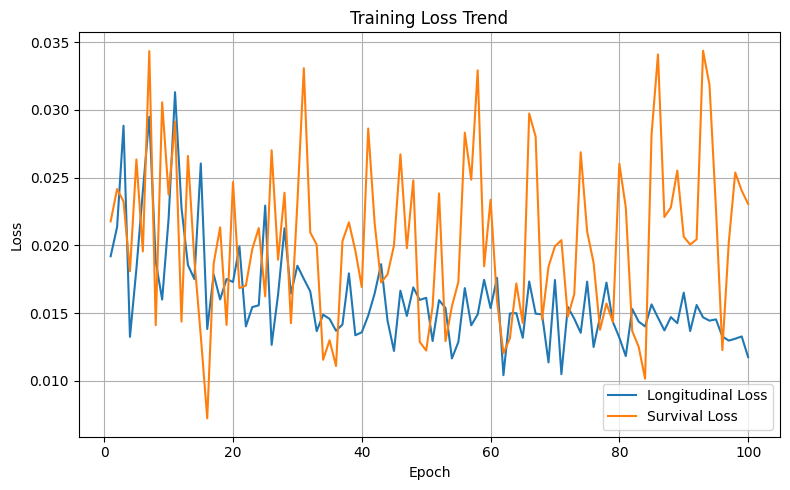

In [3]:
import matplotlib.pyplot as plt
import os
n_epoch = 100

# Store per-epoch losses for plotting
long_losses = []
surv_losses = []

for epoch in range(n_epoch):
    print("=" * 50)
    print(f"Epoch {epoch + 1}/{n_epoch}")
    print("=" * 50)

    model = model.train()
    running_loss = 0
    tokens = 0

    # Shuffle IDs
    train_id = np.random.permutation(train_id)
    vali_id = np.random.permutation(vali_id)

    for batch in range(0, len(train_id), args.batch_size):
        optimizer.zero_grad()

        # Get batch data
        indices = train_id[batch:batch + args.batch_size]
        batch_data = train_data[train_data["id"].isin(indices)].copy()

        # Prepare tensors
        batch = get_tensors(batch_data, long=Y_str_list, device=device)

        # Forward pass
        long_preds, surv_inten = model(batch)

        # Loss computation
        loss1, full_loss1, num_tokens = long_loss(long_preds, batch)
        loss2, full_loss2 = surv_loss_lsr(surv_inten, batch)

        # Combined loss
        loss = loss1 + args.surv_weight * loss2
        loss.backward()
        optimizer.step()

        running_loss += (full_loss1 +  full_loss2).item()
        tokens += num_tokens

    # Epoch stats
    train_show = running_loss / tokens
    print(f"Avg training loss per token: {train_show:.4f}")
    print(f"  long loss  : {loss1.item():.4f}")
    print(f"  surv loss  : {loss2.item():.4f}")

    # Save losses for plotting
    long_losses.append(loss1.item())
    surv_losses.append((args.surv_weight * loss2).item())

# After training: plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epoch + 1), long_losses, label='Longitudinal Loss')
plt.plot(range(1, n_epoch + 1), surv_losses, label='Survival Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/loss_trend.png")
plt.show()


In [ ]:


model.eval()
all_long_preds = []  # optional: to store long_preds for analysis (not used in metrics)

# Containers for accumulating predictions and truths for each landmark and horizon
predictions = {LT: {w: [] for w in pred_windows} for LT in landmark_times}
truths      = {LT: {w: [] for w in pred_windows} for LT in landmark_times}

with torch.no_grad():
    for batch in val_loader:
        # Unpack batch data (assuming these are provided by the DataLoader)
        x_long, x_static, mask, event_time, event_indicator = batch  
        x_long, x_static, mask = x_long.to(device), x_static.to(device), mask.to(device)
        event_time, event_indicator = event_time.to(device), event_indicator.to(device)

        # Iterate over each landmark time
        for LT in landmark_times:
            # Prepare input data up to the landmark time LT by masking out future time steps
            # (Assuming time_steps are discretized such that each index corresponds to one time unit)
            time_indices = torch.arange(x_long.shape[1], device=x_long.device)  # sequence indices [0,1,...,max_seq_len-1]
            # Create a mask for steps <= LT (True = use step, False = beyond LT)
            time_mask = time_indices.unsqueeze(0) <= LT  
            time_mask = time_mask & (mask == 1)  # ensure we don't include padded steps beyond each sample's actual length

            # Truncate the longitudinal data beyond LT (optional: zero out features beyond LT)
            x_long_trunc = x_long.clone()
            x_long_trunc[~time_mask] = 0.0
            mask_trunc = time_mask.float()  # truncated mask as float (if model expects float mask)

            # Forward pass through the model with truncated data up to LT
            long_preds, surv_inten = model(x_long_trunc, x_static, mask_trunc)
            all_long_preds.append(long_preds.detach().cpu())  # store long_preds (optional)

            # Convert surv_inten to survival probabilities S(t) for each time step  
            # (Assuming surv_inten[:, t] represents the hazard/intensity for interval t->t+1)
            hazard = surv_inten.clone()
            hazard = hazard.clamp(min=0.0, max=1.0)  # ensure hazard is in [0,1]
            # Initialize survival probability tensor (same shape as hazard)
            survival_prob = torch.ones_like(hazard)
            if hazard.shape[1] > 1:
                # survival_prob[:, 0] = 1 by initialization; compute cumulative survival for t >= 1
                survival_prob[:, 1:] = torch.cumprod(1 - hazard[:, :-1], dim=1)

            # Now survival_prob[:, t] = P(T > t) (survival probability *through* time t)

            # Evaluate survival predictions for each future prediction window from this landmark
            for w in pred_windows:
                target_time = LT + w
                if target_time >= survival_prob.shape[1]:
                    # Skip if target horizon is beyond model output range
                    continue

                # Predicted conditional survival P(T > LT + w | T > LT) = S(LT+w) / S(LT)
                S_LT     = survival_prob[:, LT]         # predicted survival up to landmark time LT
                S_target = survival_prob[:, target_time]  # predicted survival up to time LT + w
                # Avoid division by zero (if S_LT is 0, set conditional survival to 0)
                cond_surv_pred = torch.zeros_like(S_target)
                nonzero_mask = S_LT > 0
                cond_surv_pred[nonzero_mask] = S_target[nonzero_mask] / S_LT[nonzero_mask]
                cond_surv_pred = cond_surv_pred.cpu().numpy()  # move to CPU for metrics

                # Determine true conditional survival outcomes for this horizon
                # (1 if survived from LT to LT+w, 0 if event occurred by LT+w)
                for i in range(len(event_time)):
                    t_i = event_time[i].item()        # true event or censor time for sample i
                    e_i = event_indicator[i].item()   # event indicator (1=event occurred, 0=censored)

                    if t_i <= LT:
                        continue  # sample i is not at risk at LT (event happened before or at LT)
                    # If censored before or at target_time, skip (outcome at horizon is unknown)
                    if e_i == 0 and t_i <= target_time:
                        continue

                    # Determine true survival status at time (LT + w)
                    if e_i == 1 and t_i <= target_time:
                        true_label = 0.0  # event occurred by the horizon (did not survive to LT+w)
                    else:
                        true_label = 1.0  # no event by horizon (survived at least to LT+w)
                    truths[LT][w].append(true_label)
                    predictions[LT][w].append(cond_surv_pred[i])

# After accumulating predictions and truths, compute AUC and Brier score for each landmark and horizon
metrics = {LT: {} for LT in landmark_times}
for LT in landmark_times:
    for w in pred_windows:
        if len(truths[LT][w]) == 0:
            continue  # no data to evaluate for this horizon
        y_true = np.array(truths[LT][w])
        y_pred = np.array(predictions[LT][w])
        # Use existing metric functions to compute AUC and Brier Score
        auc_val = compute_auc(y_true, y_pred)
        brier_val = compute_brier(y_true, y_pred)
        metrics[LT][w] = {"AUC": auc_val, "Brier": brier_val}

# `metrics` now holds the AUC and Brier score for each landmark time and prediction window.


tensor([[0.6827, 0.5369, 0.5267, 0.5119, 0.5630, 0.5961, 0.6607, 0.6391, 0.6486,
         0.7463, 0.5539],
        [0.7406, 0.5018, 0.5831, 0.5876, 0.5605, 0.6293, 0.6207, 0.5953, 0.6329,
         0.6262, 0.5318],
        [0.5743, 0.5282, 0.5381, 0.5086, 0.5518, 0.5462, 0.6390, 0.5589, 0.5813,
         0.5802, 0.5985],
        [0.6152, 0.6395, 0.7010, 0.5756, 0.6175, 0.4518, 0.5542, 0.4922, 0.5597,
         0.5416, 0.6150],
        [0.5095, 0.4911, 0.5415, 0.6340, 0.4708, 0.5167, 0.5424, 0.5551, 0.4798,
         0.5428, 0.4941],
        [0.5436, 0.5347, 0.5602, 0.5997, 0.5642, 0.5490, 0.4324, 0.5277, 0.6011,
         0.6437, 0.5751],
        [0.6200, 0.4745, 0.6064, 0.6861, 0.7723, 0.5145, 0.5630, 0.5499, 0.5817,
         0.6382, 0.7006],
        [0.6810, 0.6403, 0.6411, 0.6103, 0.6267, 0.6989, 0.6151, 0.5714, 0.5878,
         0.6318, 0.7011]], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [4]:
from util import surv_loss_lsr
surv_loss_lsr(surv_inten, batch)


NameError: name 'a' is not defined

In [14]:
batch = get_tensors(train_data, long=Y_str_list, device=device)

In [33]:
a = batch["intenmask"][0,1:]
# Find the first index where death_mask is True
idx = torch.argmax(a.int()).item()  # returns 0 if all False
surv_mask = torch.zeros_like(a)
if a.any():
    surv_mask[:idx] = True
print(surv_mask)

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False, False,
        False], device='cuda:0')


In [7]:
model = model.eval()
vali_loss = 0
tokens = 0

for batch in range(0, len(vali_id), args.batch_size):
    indices = vali_id[batch:batch + args.batch_size]
    batch_data = vali_data[vali_data["id"].isin(indices)]
    batch = get_tensors(batch_data.copy(), long=Y_str_list, device=device)

    with torch.no_grad():
        long_preds, visit_inten, surv_inten = model(batch)
        loss1, full_loss1, num_tokens = long_loss(long_preds, batch)
        # loss2, full_loss2 = surv_loss(surv_inten, Zeta, batch)

    vali_loss += full_loss1.item()
    tokens += num_tokens

# ---- Evaluation outputs ----
event_ll = (torch.log(visit_inten[0]) * batch["longmask"][0, 1:]).sum()
non_event_ll = batch["mask"][0].sum()
visit_ll = event_ll - non_event_ll



# Detailed visit comparison
first_traj_len = torch.sum(batch["mask"][0], dim=-1).cpu().numpy()
print(f"sample trajectory visit intensities: {np.log(visit_inten[0, :first_traj_len - 1].detach().cpu().numpy())}")

ground_intensities = batch_data["true_inten"].to_numpy()[:first_traj_len - 1]
print(f"ground truth visit event intensities: {np.log(ground_intensities)}")

total_time = batch["obstime"][0][1:first_traj_len]
print(f"times: {total_time}")

# Survival examination
surv_event_ll = (torch.log(surv_inten[0]) * batch["intenmask"][0, 1:]).sum(dim=-1)
non_surv_event_ll = batch["mask"][0].sum(dim=-1)
surv_ll = surv_event_ll - non_surv_event_ll

print(f"sample trajectory survival event intensity: {surv_event_ll.item():.2f}")
print(f"sample trajectory survival non-event intensity: {non_surv_event_ll.item():.2f}")

ground_truth_surv_ll = batch_data["surv_ll"].to_numpy()[0]
print(f"ground truth survival event intensity: {ground_truth_surv_ll:.2f}")

ground_truth_surv_non_ll = batch_data["surv_non_ll"].to_numpy()[0]
print(f"ground truth survival NON-event intensity: {ground_truth_surv_non_ll:.2f}")

# Detailed survival comparison
first_traj_len = torch.sum(batch["mask"][0], dim=-1).cpu().numpy()
print(f"sample trajectory surv intensities: {np.log(surv_inten[0, :first_traj_len].detach().cpu().numpy())}")

ground_surv_intensities = batch_data["true_surv"].to_numpy()[:first_traj_len]
print(f"ground truth surv intensities: {np.log(ground_surv_intensities)}")

total_time = batch["totaltime"][0][1:first_traj_len + 1]
print(f"times: {total_time}")

# Save best model
vali_show = vali_loss / tokens

if vali_show < curr_best:
    curr_best = vali_show
    print(f"updated at epoch: {epoch}")
    print(f"current best validation loss: {curr_best:.2f}")
    torch.save(model.state_dict(), model_save_path)


visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([16, 11, 48])
inten weight shape: torch.Size([1, 48])
visit_x shape: torch.Size([8, 11, 48])
i

KeyError: 'event_ll'